In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.cifar_resnet import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN

In [2]:
exp_id = 2

model_name = 'cifar10_resnet_exp%d.h5' % exp_id
net = PreActResNet(PreActBlock, [2, 2, 2, 2])
net = net.to('cuda')

In [3]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

In [4]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_cifar10_all(
    '/data', val_size=0.1, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


---
## DkNN

In [6]:
layers = ['layer2']
with torch.no_grad():
    dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
                k=75, num_classes=10)
    y_pred = dknn.classify(x_test)

In [7]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.7212

In [8]:
cred = dknn.credibility(y_pred)

(array([ 200.,  922., 1161., 1441., 1320., 1010., 1075.,  929., 1036.,
         906.]),
 array([0.103 , 0.1927, 0.2824, 0.3721, 0.4618, 0.5515, 0.6412, 0.7309,
        0.8206, 0.9103, 1.    ]),
 <a list of 10 Patch objects>)

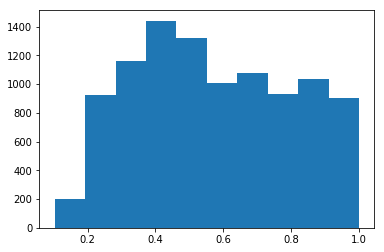

In [9]:
plt.hist(cred)

In [10]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

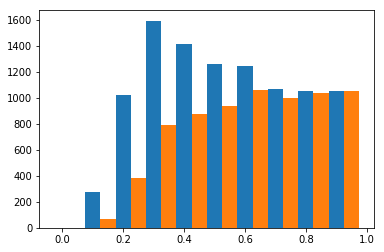

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [12]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([       nan, 0.24909747, 0.37073171, 0.49780564, 0.6187456 ,
       0.74503574, 0.84991974, 0.93283582, 0.98766603, 1.        ])

---
## DkNN Attack

In [14]:
attack = DKNNAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y_test[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=5,
            max_iterations=500, learning_rate=1e-1,
            initial_const=1e2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000], 100)

    step: 0; loss: -516.040; l2dist: 0.000
    step: 50; loss: -523.962; l2dist: 1.598
    step: 100; loss: -524.317; l2dist: 1.585
    step: 150; loss: -524.388; l2dist: 1.591
    step: 200; loss: -524.414; l2dist: 1.593
    step: 250; loss: -524.438; l2dist: 1.595
    step: 300; loss: -524.452; l2dist: 1.598
    step: 350; loss: -524.496; l2dist: 1.595
    step: 400; loss: -524.463; l2dist: 1.598
    step: 450; loss: -524.486; l2dist: 1.599
tensor(83., device='cuda:0')
binary step: 0; number of successful adv: 83/100
    step: 0; loss: -1093.707; l2dist: 0.000
    step: 50; loss: -1110.023; l2dist: 1.633
    step: 100; loss: -1112.653; l2dist: 1.611
    step: 150; loss: -1113.238; l2dist: 1.609
    step: 200; loss: -1113.384; l2dist: 1.615
    step: 250; loss: -1113.403; l2dist: 1.616
    step: 300; loss: -1113.230; l2dist: 1.609
tensor(84., device='cuda:0')
binary step: 1; number of successful adv: 88/100
    step: 0; loss: -6481.368; l2dist: 0.000
    step: 50; loss: -6571.679; l2d

    step: 300; loss: -1314.137; l2dist: 1.674
    step: 350; loss: -1314.036; l2dist: 1.665
    step: 400; loss: -1314.351; l2dist: 1.668
    step: 450; loss: -1314.450; l2dist: 1.662
tensor(84., device='cuda:0')
binary step: 1; number of successful adv: 85/100
    step: 0; loss: -8028.462; l2dist: 0.000
    step: 50; loss: -8180.443; l2dist: 2.043
    step: 100; loss: -8214.993; l2dist: 2.012
    step: 150; loss: -8224.743; l2dist: 2.023
    step: 200; loss: -8226.910; l2dist: 2.045
    step: 250; loss: -8231.486; l2dist: 2.042
    step: 300; loss: -8227.948; l2dist: 2.060
tensor(74., device='cuda:0')
binary step: 2; number of successful adv: 87/100
    step: 0; loss: -68001.242; l2dist: 0.000
    step: 50; loss: -69358.766; l2dist: 2.083
    step: 100; loss: -69638.891; l2dist: 2.205
    step: 150; loss: -69727.805; l2dist: 2.292
    step: 200; loss: -69769.055; l2dist: 2.352
    step: 250; loss: -69791.531; l2dist: 2.397
    step: 300; loss: -69816.695; l2dist: 2.435
    step: 350; 

    step: 150; loss: -4137.229; l2dist: 1.606
    step: 200; loss: -4140.210; l2dist: 1.607
    step: 250; loss: -4140.846; l2dist: 1.612
    step: 300; loss: -4142.563; l2dist: 1.621
    step: 350; loss: -4143.608; l2dist: 1.616
    step: 400; loss: -4142.894; l2dist: 1.620
tensor(80., device='cuda:0')
binary step: 2; number of successful adv: 93/100
    step: 0; loss: -36516.023; l2dist: 0.000
    step: 50; loss: -37200.973; l2dist: 1.540
    step: 100; loss: -37369.133; l2dist: 1.609
    step: 150; loss: -37449.164; l2dist: 1.665
    step: 200; loss: -37478.355; l2dist: 1.703
    step: 250; loss: -37490.070; l2dist: 1.725
    step: 300; loss: -37515.641; l2dist: 1.745
    step: 350; loss: -37523.078; l2dist: 1.754
    step: 400; loss: -37523.988; l2dist: 1.768
    step: 450; loss: -37526.395; l2dist: 1.790
tensor(80., device='cuda:0')
binary step: 3; number of successful adv: 93/100
    step: 0; loss: -361961.844; l2dist: 0.000
    step: 50; loss: -368808.438; l2dist: 1.407
    step

    step: 150; loss: -32356.434; l2dist: 1.560
    step: 200; loss: -32389.898; l2dist: 1.592
    step: 250; loss: -32410.896; l2dist: 1.608
    step: 300; loss: -32427.836; l2dist: 1.623
    step: 350; loss: -32429.041; l2dist: 1.632
    step: 400; loss: -32430.439; l2dist: 1.647
    step: 450; loss: -32447.520; l2dist: 1.652
tensor(78., device='cuda:0')
binary step: 3; number of successful adv: 95/100
    step: 0; loss: -262322.188; l2dist: 0.000
    step: 50; loss: -266792.906; l2dist: 1.359
    step: 100; loss: -268521.000; l2dist: 1.402
    step: 150; loss: -269270.875; l2dist: 1.445
    step: 200; loss: -269548.719; l2dist: 1.471
    step: 250; loss: -269788.406; l2dist: 1.499
    step: 300; loss: -269822.406; l2dist: 1.509
    step: 350; loss: -269923.781; l2dist: 1.531
    step: 400; loss: -270004.469; l2dist: 1.539
    step: 450; loss: -270039.719; l2dist: 1.547
tensor(69., device='cuda:0')
binary step: 4; number of successful adv: 95/100


In [ ]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    print((y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred))

In [ ]:
with torch.no_grad():
    y_clean = dknn.classify(x_test[:1000])
    ind = (y_clean.argmax(1) == y_test[:1000].numpy()) & (y_pred.argmax(1) != y_test[:1000].numpy())
    dist = np.mean(np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:1000][ind])**2, (1, 2, 3))))
    print(dist)

In [ ]:
cred = dknn.credibility(y_pred[ind])
plt.hist(cred)

In [ ]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().permute(1, 2, 0).numpy(), cmap='gray')
    plt.show()

---
## CW L2 on undefended network

In [29]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1e-2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000].cuda(), 100)

    step: 0; loss: 0.117; l2dist: 0.000
    step: 50; loss: 0.051; l2dist: 0.203
    step: 100; loss: 0.052; l2dist: 0.195
binary step: 0; number of successful adv: 66/100
    step: 0; loss: 0.436; l2dist: 0.000
    step: 50; loss: 0.115; l2dist: 0.283
    step: 100; loss: 0.133; l2dist: 0.278
binary step: 1; number of successful adv: 97/100
    step: 0; loss: 0.548; l2dist: 0.000
    step: 50; loss: 0.100; l2dist: 0.268
    step: 100; loss: 0.111; l2dist: 0.249
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.360; l2dist: 0.000
    step: 50; loss: 0.097; l2dist: 0.255
    step: 100; loss: 0.102; l2dist: 0.237
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.273; l2dist: 0.000
    step: 50; loss: 0.083; l2dist: 0.243
    step: 100; loss: 0.095; l2dist: 0.233
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.114; l2dist: 0.000
    step: 50; loss: 0.048; l2dist: 0.196
    step: 100; loss: 0.045; l2dist: 0.183
    step: 150;

    step: 50; loss: 0.156; l2dist: 0.306
    step: 100; loss: 0.151; l2dist: 0.287
    step: 150; loss: 0.152; l2dist: 0.294
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.546; l2dist: 0.000
    step: 50; loss: 0.110; l2dist: 0.273
    step: 100; loss: 0.101; l2dist: 0.245
    step: 150; loss: 0.166; l2dist: 0.317
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.125; l2dist: 0.000
    step: 50; loss: 0.058; l2dist: 0.220
    step: 100; loss: 0.056; l2dist: 0.209
    step: 150; loss: 0.068; l2dist: 0.243
binary step: 0; number of successful adv: 87/100
    step: 0; loss: 0.209; l2dist: 0.000
    step: 50; loss: 0.058; l2dist: 0.205
    step: 100; loss: 0.051; l2dist: 0.181
    step: 150; loss: 0.076; l2dist: 0.229
binary step: 1; number of successful adv: 98/100
    step: 0; loss: 0.330; l2dist: 0.000
    step: 50; loss: 0.058; l2dist: 0.201
    step: 100; loss: 0.055; l2dist: 0.180
    step: 150; loss: 0.058; l2dist: 0.181
binary step: 2; n

In [30]:
with torch.no_grad():
    y_pred = net(x_adv)
    print((y_pred.argmax(1).cpu() == y_test[:1000]).numpy().sum() / y_pred.size(0))

0.0


In [31]:
with torch.no_grad():
    y_clean = net(x_test[:1000].cuda())
    ind = (y_clean.argmax(1).cpu() == y_test[:1000]).numpy() & (y_pred.argmax(1).cpu() != y_test[:1000]).numpy()
    dist = np.mean(np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:1000][ind])**2, (1, 2, 3))))
    print(dist)

0.1960245


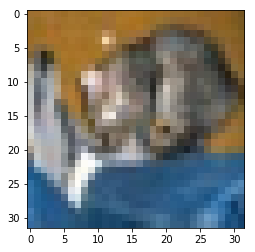

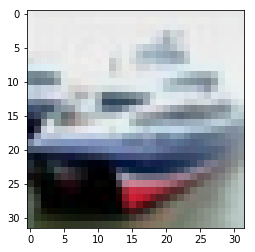

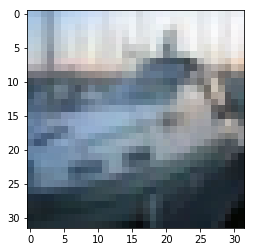

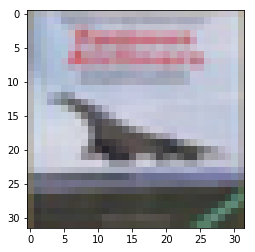

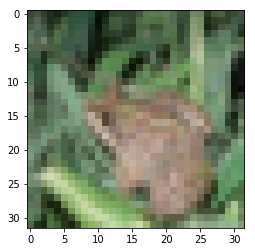

In [32]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().permute(1, 2, 0).numpy(), cmap='gray')
    plt.show()

In [33]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    print((y_pred.argmax(1) == y_test[:1000].numpy()).sum() / y_test.size(0))

0.0143
